# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad. **Listo**


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico. **Listo**


* Generar el pronóstico para los precios de los próximos siete días. **Listo**


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum. **Listo**


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.**Listo**


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum. **Listo**


##1. Procesamiento de datos

####Cargamos las librerias

In [0]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from random import seed
seed(1)
import math
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

####Construimos el conjunto de datos a partir de los datos historicos

In [0]:
#Dirección del conjunto de datos
directorio = "./Precios/"

#Nombre común para todos los archivos
nombre = "Precio_Bolsa_Nacional_($kwh)_"

#Conteo de la canitidad de archivos
cantidadXls = len(glob.glob(directorio+("*.xls")))
cantidadXlsx = len(glob.glob(directorio+"*.xlsx"))
cantidadArchivos = cantidadXlsx+cantidadXls

#Creación del conjunto de datos
conjuntoDatos = pd.DataFrame()

for año in range(1995,1995+cantidadArchivos):
  #Establecemos la extensión para cada archivo
  if año < 2016:
    extension = ".xlsx"
  else:
    extension = ".xls"

  #Creamos la ruta completa para cada archivo
  archivo = directorio+nombre+str(año)+extension
  
  #Eliminamos los encabezados para cada archivo
  if año <= 1999:
    conjuntoParcial = pd.read_excel(archivo, skiprows = 3)
  elif año > 1999:
    conjuntoParcial = pd.read_excel(archivo, skiprows = 2)
  
  #Añadimos el archivo al conjunto de datos
  conjuntoDatos=pd.concat([conjuntoDatos, conjuntoParcial],axis=0,sort=False)
  

#Creamos el encabezado para el conjunto de datos
conjuntoDatos.columns = ['Fecha', "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12","13", "14",
                         "15", "16", "17", "18", "19", "20", "21", "22", "23","Version","NaN","Unnamed"]

#Eliminamos los datos innecesarios
conjuntoDatos.drop(['Version', 'NaN','Unnamed'], axis = 'columns', inplace=True )

In [121]:
#Mostramos los cinco primeros datos para corroborar que la información esté bien organizada
conjuntoDatos.head()

,Fecha,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,1995-07-20,NaN,1.073,1.073,1.073,1.073,1.073,1.073,1.073,1.074,1.074,2.827,2.827,2.827,1.074,1.073,1.073,1.073,1.073,1.074,1.897,1.897,1.897,1.073,1.073
1,1995-07-21,1.073,1.000,1.000,1.000,1.000,1.000,5.000,6.000,6.000,6.000,6.000,9.256,9.256,5.000,5.000,1.000,1.000,5.000,12.000,16.670,11.929,5.000,1.000,1.000
2,1995-07-22,1.073,1.073,1.000,1.000,1.000,1.073,1.303,1.303,1.303,1.303,1.303,1.303,1.303,1.303,1.073,1.000,1.000,1.000,1.303,2.500,2.500,1.303,1.073,1.073
3,1995-07-23,1.073,1.000,1.000,1.000,1.000,1.000,0.100,1.000,1.000,1.000,1.000,1.000,1.238,1.238,1.000,0.100,0.100,1.000,1.238,1.238,1.238,1.238,1.073,1.000
4,1995-07-24,1.000,1.000,0.990,1.000,1.000,1.073,3.000,3.000,3.000,3.500,8.845,9.256,3.000,1.073,1.073,1.073,3.000,2.000,18.630,22.500,9.256,3.000,1.073,1.000


In [0]:
#Cambiamos los NaN por cero
for i in range(0,24):
  conjuntoDatos[str(i)].fillna(0,inplace=True)

In [123]:
#Comprobamos el tipo de los datos
conjuntoDatos.dtypes

Fecha     object
0        float64
1        float64
2        float64
3        float64
4        float64
5        float64
6        float64
7        float64
8        float64
9        float64
10       float64
11       float64
12       float64
13       float64
14       float64
15       float64
16       float64
17       float64
18       float64
19       float64
20       float64
21       float64
22       float64
23       float64
dtype: object

In [0]:
#Convertimos la fecha a tipo 'datetime' para trabajar con ella
conjuntoDatos['Fecha'] = pd.to_datetime(conjuntoDatos['Fecha'])

####Calculamos el promedio diario

In [125]:
#Calculamos el promedio por cada fecha y lo añadimos al dataframe
conjuntoDatos['Promedio'] = conjuntoDatos.mean(axis=1)
#Mostramos el promedio de las cinco primeras fechas
conjuntoDatos[['Fecha','Promedio']].head()

,Fecha,Promedio
0,1995-07-20,1.350708
1,1995-07-21,4.924333
2,1995-07-22,1.269500
3,1995-07-23,0.953083
4,1995-07-24,4.305917


#####Comprobamos si existen datos repetidos

In [126]:
#Creamos un dataframe auxiliar para guardar las fechas repetidas
duplicados = conjuntoDatos[conjuntoDatos['Fecha'].duplicated(keep=False)]
#Odenamos el dataframe por fecha
duplicados=duplicados.sort_values('Fecha')
#Mostramos las 10 primeras fechas para comprobar que se trata de fechas repetidas
duplicados.head(10)

,Fecha,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,Promedio
1,1996-01-02,10.0,10.0,10.0,10.0,10.0,13.0,10.0,13.7,20.0,29.728,29.728,30.0,13.44,13.44,12.0,12.0,12.0,12.0,15.0,20.0,14.30,12.0,25.0,12.000,15.389000
373,1996-01-02,10.0,10.0,10.0,10.0,10.0,13.0,10.0,13.7,20.0,29.728,29.728,30.0,13.44,13.44,12.0,12.0,12.0,12.0,15.0,20.0,14.30,12.0,25.0,12.000,15.389000
2,1996-01-03,12.0,10.0,10.0,10.0,12.0,13.0,21.2,30.0,30.0,30.000,30.000,30.0,30.00,30.00,30.0,10.0,10.0,10.0,15.0,15.0,30.92,12.0,30.0,10.999,19.671625
374,1996-01-03,12.0,10.0,10.0,10.0,12.0,13.0,0.0,30.0,30.0,30.000,30.000,30.0,30.00,30.00,30.0,10.0,10.0,10.0,15.0,15.0,30.92,12.0,30.0,10.999,18.788292
3,1996-01-04,12.8,13.0,12.0,12.0,13.0,13.0,30.0,30.0,30.0,30.000,30.000,30.0,30.00,30.00,30.0,20.0,20.0,20.0,40.0,40.0,32.00,15.0,20.0,13.000,23.575000
375,1996-01-04,12.8,13.0,12.0,12.0,13.0,13.0,30.0,30.0,30.0,30.000,30.000,30.0,30.00,30.00,30.0,20.0,20.0,20.0,40.0,40.0,32.00,15.0,20.0,13.000,23.575000
4,1996-01-05,18.0,17.0,17.0,17.0,18.0,18.0,20.0,35.0,40.0,40.000,40.000,40.0,40.00,40.00,35.0,15.0,15.0,15.0,40.0,40.0,30.00,18.0,20.0,18.000,26.916667
376,1996-01-05,18.0,17.0,17.0,17.0,18.0,18.0,20.0,35.0,40.0,40.000,40.000,40.0,40.00,40.00,35.0,15.0,15.0,15.0,40.0,40.0,30.00,18.0,20.0,18.000,26.916667
5,1996-01-06,14.0,12.0,12.0,12.0,14.0,14.3,20.0,30.0,40.0,40.000,40.000,40.0,40.00,40.00,30.0,14.0,14.0,14.0,28.0,40.0,28.00,21.0,20.0,14.000,24.637500
377,1996-01-06,14.0,12.0,12.0,12.0,14.0,14.3,20.0,30.0,40.0,40.000,40.000,40.0,40.00,40.00,0.0,14.0,14.0,14.0,28.0,40.0,28.00,21.0,20.0,14.000,23.387500


In [0]:
#Eliminamos los datos repetidos
conjuntoDatos.drop_duplicates(subset='Fecha',keep='first',inplace=True)

In [128]:
#Sacamos las columnas innecesarias del conjunto de datos
conjuntoDatos=conjuntoDatos[['Fecha','Promedio']]
conjuntoDatos.head()

,Fecha,Promedio
0,1995-07-20,1.350708
1,1995-07-21,4.924333
2,1995-07-22,1.269500
3,1995-07-23,0.953083
4,1995-07-24,4.305917


####Graficamos el promedio de los precios de energía

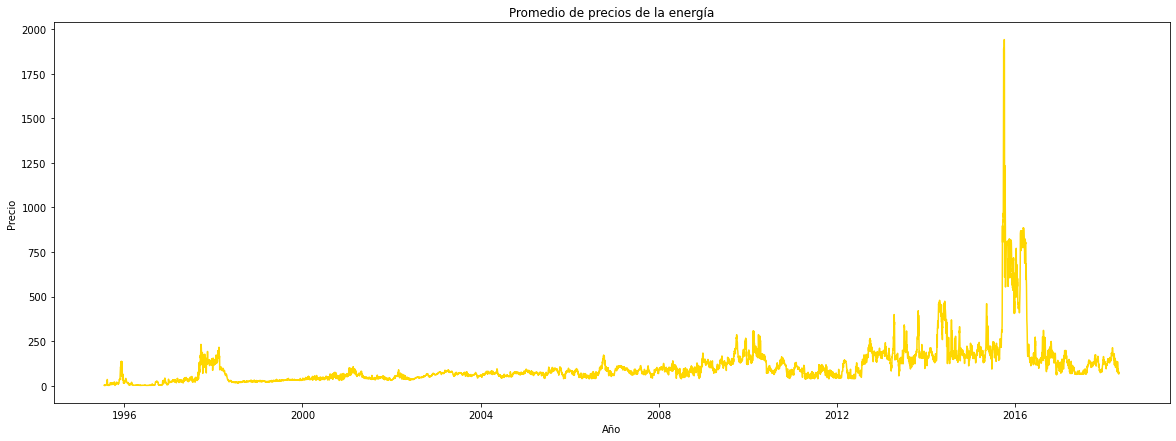

In [129]:
#Graficamos el conjunto de datos
plt.figure(figsize=(20,7))
plt.title('Promedio de precios de la energía')
plt.ylabel('Precio')
plt.xlabel('Año')
plt.plot(conjuntoDatos['Fecha'], conjuntoDatos['Promedio'], color='gold')
plt.show()

####Realizamos el procesamiento de datos para el IPC

In [130]:
#Cargamos el conjunto de datos del IPC eliminando las primeras filas, ya que no contienen información relevante
IPC = pd.read_excel('./Datos/IPC.xlsx',skiprows=12)
#Mostramos los primeros datos del IPC con el fin de determinar que columnas son necesarias
IPC.head()

,Año(aaaa)-Mes(mm),Índice,Inflación anual,Inflación mensual,Inflación año corrido
0,202002,104.94,0.0372,0.0067,0.0109
1,202001,104.24,0.0362,0.0042,0.0042
2,201912,103.80,0.0380,0.0026,0.0380
3,201911,103.54,0.0384,0.0010,0.0354
4,201910,103.43,0.0386,0.0016,0.0343


In [0]:
#Eliminamos las ultimas filas ya que contienen unformación irrelevante
IPC.drop(range(788,794),axis=0,inplace=True)

In [132]:
#Dado que solo necesitamos la fecha y el indice eliminamos las columnas innecesarias
IPC.drop(['Inflación anual', 'Inflación mensual','Inflación año corrido'], axis = 'columns', inplace=True )
IPC.head()

,Año(aaaa)-Mes(mm),Índice
0,202002,104.94
1,202001,104.24
2,201912,103.80
3,201911,103.54
4,201910,103.43


In [0]:
#Cambiamos el nombre de las columnas por comodidad
IPC.columns = ['FechaIPC', 'Indice']

In [134]:
#Observamos el tipo de los datos para detectar si es necesario realizar conversiones
IPC.dtypes

FechaIPC     object
Indice      float64
dtype: object

In [0]:
#Convertimos la fecha del IPC a datetime y establecemos la fecha de forma mensual
IPC['FechaIPC'] = pd.to_datetime(IPC["FechaIPC"],format="%Y%m").dt.to_period('M')
#Creamos la columna 'FechaIPC' al conjunto de datos principal con la finalidad
#De usar esta columna para unir los dos conjuntos de datos
conjuntoDatos['FechaIPC'] = pd.to_datetime(conjuntoDatos['Fecha']).dt.to_period('M')

In [136]:
#Unimos el conjunto de datos con el IPC correspondiente a cada més
conjuntoDatos=pd.merge(conjuntoDatos,IPC, on="FechaIPC")
#Mostramos el resultado del conjunto de datos unido
conjuntoDatos.head()

,Fecha,Promedio,FechaIPC,Indice
0,1995-07-20,1.350708,1995-07,20.93
1,1995-07-21,4.924333,1995-07,20.93
2,1995-07-22,1.269500,1995-07,20.93
3,1995-07-23,0.953083,1995-07,20.93
4,1995-07-24,4.305917,1995-07,20.93


In [137]:
conjuntoDatos.tail()

,Fecha,Promedio,FechaIPC,Indice
8321,2018-05-01,71.666726,2018-05,99.16
8322,2018-05-02,76.374441,2018-05,99.16
8323,2018-05-03,71.148348,2018-05,99.16
8324,2018-05-04,64.710120,2018-05,99.16
8325,2018-05-05,73.972085,2018-05,99.16


In [0]:
#Eliminamos la columna 'FechaIPC' dado que ahora no es de utilidad
conjuntoDatos.drop('FechaIPC',axis='columns', inplace=True )

####Calculamos el precio diario de la energía normalizado

In [139]:
#Como IPC base el de la fecha inicial del conjunto de datos,
#correspondiente al 20 de julio de 1995
IPCbase=20.93
conjuntoDatos['PrecioDiario']=conjuntoDatos['Promedio']*(IPCbase/conjuntoDatos['Indice'])
conjuntoDatos.head()

,Fecha,Promedio,Indice,PrecioDiario
0,1995-07-20,1.350708,20.93,1.350708
1,1995-07-21,4.924333,20.93,4.924333
2,1995-07-22,1.269500,20.93,1.269500
3,1995-07-23,0.953083,20.93,0.953083
4,1995-07-24,4.305917,20.93,4.305917


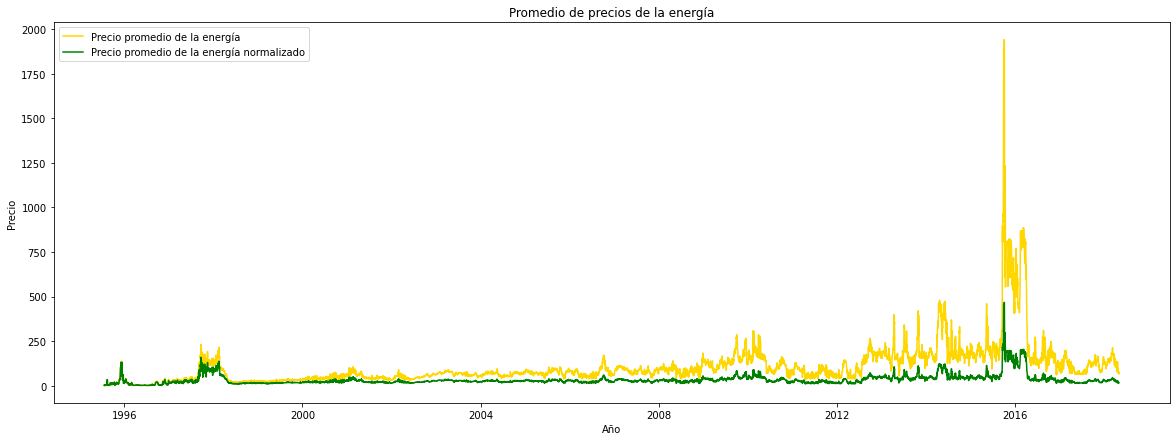

In [140]:
#Graficamos el el precio promedio y el precio normalizado
plt.figure(figsize=(20,7))
plt.title('Promedio de precios de la energía')
plt.ylabel('Precio')
plt.xlabel('Año')
plt.plot(conjuntoDatos['Fecha'], conjuntoDatos['Promedio'], color='gold',label="Precio promedio de la energía")
plt.plot(conjuntoDatos['Fecha'], conjuntoDatos['PrecioDiario'], color='green',label="Precio promedio de la energía normalizado")
plt.legend()
plt.show()

##2. Preparación de las transformaciones

In [0]:
#Creamos el conjunto de datos para los datos transformados
conjuntosTransformados=pd.DataFrame()
#Añadimos las columnas de 'Fecha' y 'PrecioDiario' 
conjuntosTransformados['Fecha']=conjuntoDatos['Fecha']
conjuntosTransformados['Precio diario']=conjuntoDatos['PrecioDiario']
#Añadimos la columna de la transformación logaritmica 
conjuntosTransformados['Logaritmo']=np.log(conjuntoDatos['PrecioDiario'])
#Añadimos la columna de la transformación raiz cuadrada
conjuntosTransformados['Raiz cuadrada']=np.power((conjuntoDatos['PrecioDiario']),(1/2))
#Añadimos la columna de la transformación cubica
conjuntosTransformados['Raiz cubica']=np.power((conjuntoDatos['PrecioDiario']),(1/3))

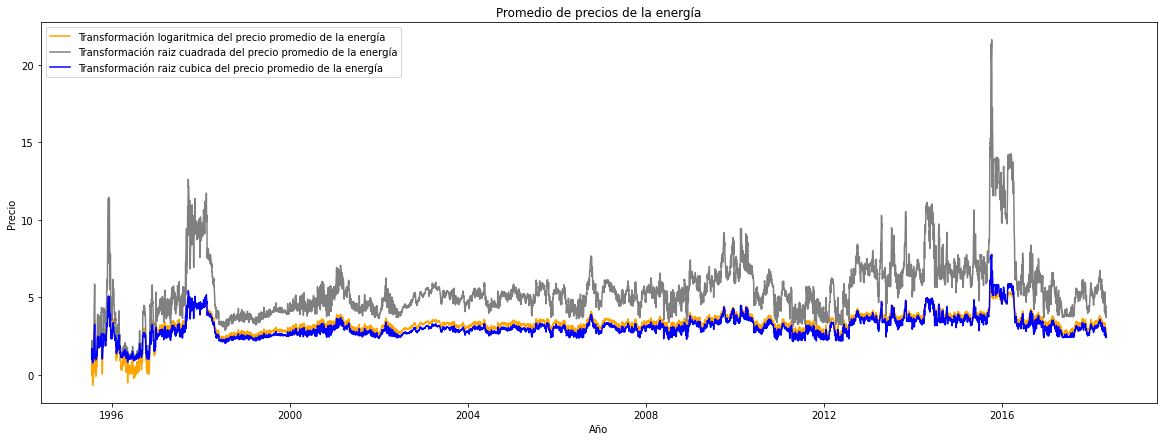

In [142]:
#Graficamos las transofrmaciones con la finalidad de ver sus comportamientos
plt.figure(figsize=(20,7))
plt.title('Promedio de precios de la energía')
plt.ylabel('Precio')
plt.xlabel('Año')
plt.plot(conjuntosTransformados['Fecha'], conjuntosTransformados['Logaritmo'], color='orange',label="Transformación logaritmica del precio promedio de la energía")
plt.plot(conjuntosTransformados['Fecha'], conjuntosTransformados['Raiz cuadrada'], color='gray',label="Transformación raiz cuadrada del precio promedio de la energía")
plt.plot(conjuntosTransformados['Fecha'], conjuntosTransformados['Raiz cubica'], color='blue',label="Transformación raiz cubica del precio promedio de la energía")
plt.legend()
plt.show()

De la grafica anterior podemos destacar que la transformación logaritmo presenta valores menores o iguales a cero, lo cual nos puede indicar que la transofrmación será descartada dado que posiblemente pueda incurrir en errores. Para poder concluir y decidir sobre las transformciones se procede a la creación del modelo.

##2. Preparación del modelo y pronostico

Se prepara el modelo utilizando la implementación de adaline utilizada en la clase, añadiendo **momentum** y la cual contiene **gradiente decendente**

In [0]:
class Adaline:
    def __init__(self,
                 learning_rate=0.001, # tasa de aprendizaje
                 max_epochs=100,      # número máximo de iteraciones sobre el set de datos
                 shuffle=False,       # mezcla patrones para aprendizaje online
                 random_state=None,   #
                 warm_start=False,    #
                 momentum=0):         # momentum

        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.shuffle = shuffle
        self.random_state = random_state
        self.warm_start = warm_start
        self.coef_ = None
        self.intercept_ = None
        self.momentum=momentum

    def fit(self, X, y):

        if not isinstance(X, np.ndarray):
            X = np.array(X)
        if not isinstance(y, np.ndarray):
            d = np.array(y)
        else:
            d = y.copy()

        if self.random_state is not None:
            np.random.RandomState(self.random_state)

        if self.coef_ is None or self.warm_start is False:
            self.coef_ = np.random.uniform(-1, 1, X.shape[1])

        if self.intercept_ is None  or self.warm_start is False:
            self.intercept_ = np.random.uniform(-1, 1, 1)

        errors2 = []
        forecasts = []

        for epoch in range(self.max_epochs):

            if self.shuffle is True:
                n = list(range(X.shape[0]))
                np.random.shuffle(n)
                X = X[n,:]
                d = d[n]

            for i in range(X.shape[0]):
                u = np.dot(X[i,:], self.coef_) + self.intercept_
                e = (d[i] - u)[0]
                self.coef_ += 2 * self.learning_rate * e * X[i,:]+(self.momentum*self.coef_) #Se añade el momentum
                self.intercept_ += 2 * self.learning_rate * e+(self.momentum*self.intercept_) #Se añade el momentum
                errors2.append(e**2)
                forecasts.append(u)

        return errors2, forecasts

    def predict(self, X):
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        u = np.dot(X, self.coef_) + self.intercept_
        return u

In [0]:
#Creamos una lista auxiliar con el nombre de las columnas del conjunto de dato que contiene las
#transformaciones para hacer mas fácil su manipulación
datosTransformados=['Precio diario','Logaritmo','Raiz cuadrada','Raiz cubica']

Encontramos el modelo optimo junto con los rezagos, la tasa de aprendizaje y el momentum que mejor desempeño aporten

In [0]:
#Rango de los rezagos
Ls=range(7,13)

#Partición de datos para comparar las predicciones, para lo cual se usan los utlimos 7 registros
n = conjuntosTransformados['Precio diario'].size
partePrediccion = conjuntosTransformados.iloc[(n - 7):]['Precio diario']

#Se crea el dataframe de todos los posibles modelos
posiblesModelos = pd.DataFrame(columns = ["Modelo","Error de pronostico","Error de entrenamiento","Rezagos/L","Momentum","Tasa de aprendizaje"])

#Iteramos para cada una de las transformaciones y el modelo base con la finalidad de encontrar cual se adapta mejor
for transformacion in datosTransformados:
    #Realizamos el escalamiento de los datos
    escalado = MinMaxScaler()
    d=np.asarray(conjuntosTransformados[transformacion]).reshape(-1,1)
    escalado.fit(d)
    d=escalado.transform(d).ravel()

    #Iteramos sobre los posibles rezagos definidos anteriormente para encontrar el mas optimo
    for L in Ls:
      #Iteramos sobre la tasa de aprendizaje con la finalidad de buscar el mas optimo
        for tasaAprendizaje in np.arange(0.005, 0.1, 0.005):
          #Iteramos sobre los posibles valores del momentum con el fin de encontrar el mas optimo para nuestro modelo
            for momentum in np.arange(0.00000, 0.0001,0.00005):#Se utilizan valores bajos dado que haciendo tanteo fueron los que mejor resultado dieron
                
                #Se usa la implementación adaline definido anteriormente
                X = []
                for t in range(L,len(d)):
                    X.append(d[t-L:t].copy())
                adaline = Adaline(
                    learning_rate=tasaAprendizaje, # tasa de aprendizaje
                    max_epochs=1,                  # número máximo de iteraciones sobre el set de datos
                    shuffle=False,                 # mezcla patrones para aprendizaje online
                    random_state=123,              # corrida reproducible
                    warm_start=False,              # inicia con pesos aleatorios
                    momentum = momentum)           #Momentum  
                errors2, forecasts = adaline.fit(
                    X, 
                    d[L:])
                
                #Se realiza el pronostico de los siguientes 7 días
                Pronosticados = []
                for i in range(0,7):
                    nuevaPrediccion = adaline.predict(X[-1])
                    proximo = np.append(X[-1][1:L], [nuevaPrediccion])
                    X = np.concatenate( ( X, [proximo] ), axis=0) 
                    Pronosticados.append(nuevaPrediccion[0])

                #Invertimos el escalamiento de datos para volver a los iniciales
                Pronosticados = escalado.inverse_transform(np.asarray(Pronosticados).reshape(-1,1)).ravel() 
                forecasts = escalado.inverse_transform(np.asarray(forecasts).reshape(-1,1)).ravel()

                #Realizamos la transformación inversa para tener congruencia con los datos originales
                if transformacion=='Logaritmo':
                    Pronosticados = np.exp(Pronosticados)  
                    forecasts = np.exp(forecasts)
                elif transformacion=='Raiz Cuadrada':
                    Pronosticados = np.power(Pronosticados,2)  
                    forecasts = np.power(forecasts,2)
                elif transformacion=='Raiz cubica':
                    Pronosticados = np.power(Pronosticados,3)  
                    forecasts = np.power(forecasts,3)

                #Encontramos el error de pronostico y el error de entrenamiento
                errorPronostico = np.sum(np.power(np.array(partePrediccion) - Pronosticados, 2))   
                sumaErrores = np.sum(errors2)
                
                #Guardamos los datos del modelo
                posiblesModelos = posiblesModelos.append({
                    "Modelo": transformacion,
                    "Error de pronostico": errorPronostico,
                    "Error de entrenamiento": sumaErrores,
                    "Rezagos/L": L,
                    "Momentum": momentum,
                    "Tasa de aprendizaje": tasaAprendizaje
                },ignore_index=True)

In [151]:
#Seleccionamos el modelo con menor error de entrenamiento
mejorModelo = posiblesModelos[posiblesModelos['Error de entrenamiento'] == min(posiblesModelos['Error de entrenamiento'])] 
#Mostramos el mejor modelo
mejorModelo

,Modelo,Error de pronostico,Error de entrenamiento,Rezagos/L,Momentum,Tasa de aprendizaje
74,Precio diario,89.781787,3.033316,8,0.0,0.095


Graficamos el mejor modelo junto con el adaline para comprobar que se adapte correctamente, adicionalmente utilizamos los rezagos, el momentum y la tasa de aprendizaje optimas encontradas en el algoritmo anterior.

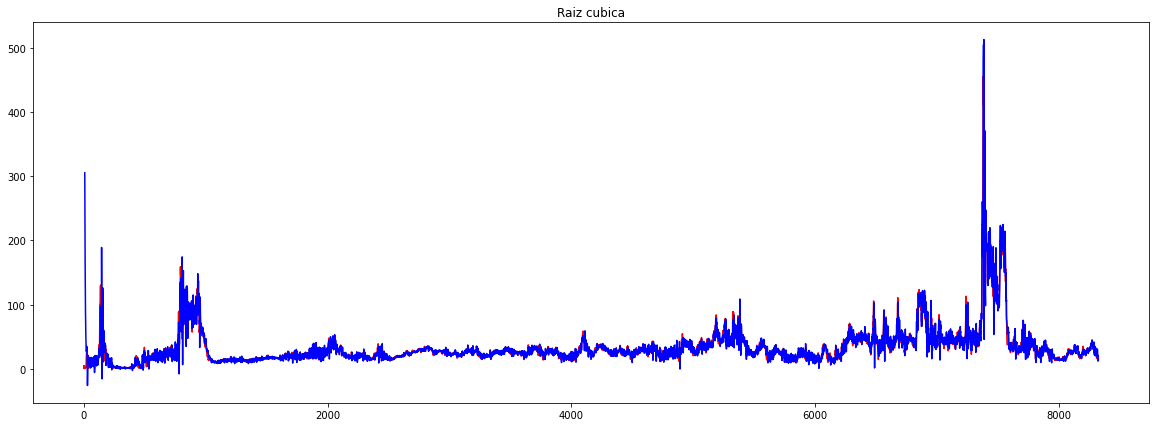

In [152]:
#Realizamos el escalamiento de los datos
escalado = MinMaxScaler()
d=np.asarray(conjuntosTransformados['Precio diario']).reshape(-1,1)
escalado.fit(d)
d=escalado.transform(d).ravel()
L=mejorModelo['Rezagos/L'].values[0]
X = []
for t in range(L, len(d)):
  X.append(d[t-L:t].copy())

#creamos el adaline
adaline = Adaline(
  learning_rate=mejorModelo['Tasa de aprendizaje'].values[0],  # tasa de aprendizaje
  max_epochs=1,        # número máximo de iteraciones sobre el set de datos
  shuffle=False,       # mezcla patrones para aprendizaje online
  random_state=123,    # corrida reproducible
  warm_start=False,    # inicia con pesos aleatorios
  momentum=mejorModelo['Momentum'].values[0])          #Momentum
  
#entrenamos el modelo 
errors2, forecasts = adaline.fit(
  X,
d[L:])

  
#Invertimos el escalado de las predcciones
forecasts=escalado.inverse_transform(np.asarray(forecasts).reshape(-1,1)).ravel()
    
#Graficamos de cada transformación y el respectivo conjunto de predicciones, para
#Visualizar el comportamiento del modelo
plt.figure(figsize=(20,7))
plt.title(transformacion)
plt.plot(conjuntosTransformados['Precio diario'], color='red');
plt.plot(range(L,len(d)), forecasts, color = 'blue');

Hallamos el pronostico de los siguientes 7 días

In [0]:
#Encontramos el pronostico para los siguientes 7 días
pronostico7Dias=[]
for proximoPronostico in range(0,7):
    Pronostico = adaline.predict(X[-1]) 
    proximo = np.append(X[-1][1:L], [Pronostico]) 
    X = np.concatenate( ( X, [proximo] ), axis=0)
    pronostico7Dias.append(Pronostico[0])
pronostico7Dias=escalado.inverse_transform(np.asarray(pronostico7Dias).reshape(-1,1)).ravel()

Finalmente revertimos la normalización del IPC y encontramos el pronostico actual

In [154]:
pronosticoFinal=pd.DataFrame()
pronosticoFinal['Precio']=pronostico7Dias*(max(conjuntoDatos['Indice'])/IPCbase)
pronosticoFinal

,Precio
0,69.155879
1,89.993169
2,100.470839
3,90.317152
4,107.342685
5,127.497316
6,134.571657
